In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, savefig

from spike_statistics.core import permutation_resampling_test, block_bootstrap

12:10:51 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "comparisons-allcells"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,gridness,border_score,information_rate,information_specificity,head_mean_ang,head_mean_vec_len,spacing,orientation,field_area,theta_score
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.466836,0.029328,1.009215,0.317256,5.438033,0.040874,0.628784,69.775141,0.412306,-0.430279
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.666792,0.308146,0.192524,0.033447,1.951740,0.017289,0.789388,62.102729,0.432396,0.307692
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.571614,0.143252,4.745836,0.393704,4.439721,0.124731,0.555402,61.189206,0.468221,-0.059705
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.428802,0.268948,0.157394,0.073553,6.215195,0.101911,0.492250,4.969741,0.425901,0.132632
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,-0.083406,0.218744,0.519153,0.032683,1.531481,0.053810,0.559905,0.000000,0.395395,0.218721


In [5]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel_group,unit_name
0,0.348023,0.275109,3.012689,0.086792,0.707197,0.149071,1833-010719-1,0.0,127.0
1,0.362380,0.166475,3.133138,0.037271,0.482486,0.132212,1833-010719-1,0.0,161.0
2,0.367498,0.266865,5.586395,0.182843,0.271188,0.062821,1833-010719-1,0.0,191.0
3,0.331942,0.312155,5.955767,0.090786,0.354018,0.052009,1833-010719-1,0.0,223.0
4,0.325842,0.180495,5.262721,0.103584,0.210427,0.094041,1833-010719-1,0.0,225.0


In [6]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,orientation,field_area,theta_score,border_score_threshold,gridness_threshold,head_mean_ang_threshold,head_mean_vec_len_threshold,information_rate_threshold,speed_score_threshold,specificity
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,69.775141,0.412306,-0.430279,0.332548,0.229073,6.029431,0.205362,1.115825,0.066736,0.451741
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,62.102729,0.432396,0.307692,0.354830,0.089333,6.120055,0.073566,0.223237,0.052594,0.098517
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,61.189206,0.468221,-0.059705,0.264610,-0.121081,5.759406,0.150827,4.964984,0.027120,0.400770
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,4.969741,0.425901,0.132632,0.344280,0.215829,6.033364,0.110495,0.239996,0.054074,0.269461
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.000000,0.395395,0.218721,0.342799,0.218967,5.768170,0.054762,0.524990,0.144702,0.133410


# Statistics about all cell-sessions

In [7]:
data.groupby('stimulated').count()['action']

stimulated
False    624
True     660
Name: action, dtype: int64

In [8]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

# celltypes

In [9]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

data = data.merge(stim_results, how='left')

waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

data = data.merge(waveform_results, how='left')

data.bs = data.bs.astype(bool)

data.loc[data.eval('t_i_peak == t_i_peak and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak != t_i_peak and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

# make baseline for inhibited vs not inhibited
data.loc[data.unit_id.isin(data.query('ns_inhibited').unit_id.values), 'ns_inhibited'] = True
data.loc[data.unit_id.isin(data.query('ns_not_inhibited').unit_id.values), 'ns_not_inhibited'] = True

In [10]:
data.loc[data.bs, 'cell_type'] = 'BS'
data.loc[data.ns_inhibited, 'cell_type'] = 'NSi'
data.loc[data.ns_not_inhibited, 'cell_type'] = 'NSn'

# Calculate statistics

In [11]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and i and Hz11', 'frequency==11 and stim_location=="ms"', 'baseline and ii and Hz30', 'frequency==30 and stim_location=="ms"']

In [12]:
columns = [
    'average_rate', 'sparsity', 'selectivity', 'information_specificity',
    'max_rate', 'information_rate', 'interspike_interval_cv', 'out_field_mean_rate', 
    'burst_event_ratio', 'specificity', 'speed_score'
]

In [14]:
results = {}
for cell_type, df in data.groupby('cell_type'):
    results[cell_type] = {}
    for key in columns:
        results[cell_type][key] = list()
        for query, label in zip(queries, labels):
            values = df.query(query).loc[:,['entity', 'unit_idnum', 'date', key]]
            results[cell_type][key].append(values.rename({key: label}, axis=1))

In [16]:
for cell_type, cell_type_val in results.items():
    for key, val in cell_type_val.items():
        df = reduce(lambda  left, right: pd.merge(left, right, on=['entity', 'unit_idnum', 'date'], how='outer'), val)
        results[cell_type][key] = df#.drop('unit_day',axis=1)

In [17]:
def drop_duplicates_least_null(df, key):
    return df.loc[df.notnull().sum(1).groupby(df[key]).idxmax()]

In [19]:
for cell_type, val in results.items():
    for key, df in val.items():
        results[cell_type][key] = drop_duplicates_least_null(df, 'unit_idnum')

In [36]:
bootstrap_results = {}
for cell_type in results:
    bootstrap_results[cell_type] = {}
    for key, df in results[cell_type].items():
        bootstrap_results[cell_type][key] = pd.DataFrame()
        group = df.groupby('entity')
        for label in labels:
            entity_values = np.array([d.loc[:, label].dropna().values for _, d in group if d.loc[:, label].count() > 0])
            if len([i for j in entity_values for i in j]) < 3: # less than total 3 samples
                boot_samples = np.ones(100) * np.nan
            else:
                boot_samples = block_bootstrap(entity_values, n_boots=100, n_samples=10, n_blocks=4, statistic=np.mean)
            bootstrap_results[cell_type][key].loc[:, label] = np.ravel(boot_samples)

In [37]:
bootstrap_results['NSi']['speed_score']

,Baseline I,11 Hz,Baseline II,30 Hz
0,NaN,0.212434,NaN,0.200387
1,NaN,0.294945,NaN,0.272048
2,NaN,0.128061,NaN,0.305037
3,NaN,0.190581,NaN,0.209126
4,NaN,0.235948,NaN,0.237550
...,...,...,...,...
95,NaN,0.198438,NaN,0.236040
96,NaN,0.157764,NaN,0.243310
97,NaN,0.147837,NaN,0.203450
98,NaN,0.175017,NaN,0.211010


# Create nice table

In [38]:
def compute_weighted_mean_sem(data, label):
    group = data.groupby('entity')
    tmp = [d.loc[:, label].dropna().values for _, d in group]
    values = np.concatenate(tmp)
    if len(values) == 0:
        return [np.nan] * 3
    weights = np.concatenate([np.ones_like(a) / len(a) for a in tmp])
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average)**2, weights=weights)
    sem = np.sqrt(variance / len(values))
    return average, sem, len(values)


def compute_confidence_interval(data, alpha=0.05):
    stat = np.sort(data.dropna())
    n = len(stat)
    if n == 0:
        return np.nan, np.nan
    low = stat[int((alpha / 2.0) * n)]
    high = stat[int((1 - alpha / 2.0) * n)]
#     low, high = np.percentile(data.dropna(), [(alpha / 2.0) * 100, (1 - alpha / 2.0) * 100])
    return low, high


def pvalue(df, df_bootstrap, control_key, case_key):
    '''
    pvalue
    '''
    case, b = df_bootstrap[case_key].dropna(), df_bootstrap[control_key].dropna()
    if len(case) == 0 or len(b) == 0:
        return np.nan
    
    n = len(case)
    
    average_case, _, _ = compute_weighted_mean_sem(df, case_key)
    average_control, _, _ = compute_weighted_mean_sem(df, control_key)
    
    low, high = compute_confidence_interval(case - average_control)
    
    case_shift = case - case.mean()
    diff = abs(average_case - average_control)    
    
    pval = (np.sum(case_shift > diff) + np.sum(case_shift < - diff)) / n
    
    return "{:.1e} [{:.2f}, {:.2f}]".format(pval, low, high)
#     return pval


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [39]:
stats = {}
for cell_type in bootstrap_results:
    stat = pd.DataFrame()

    for key, df in bootstrap_results[cell_type].items():
        Key = rename(key)
        
        for label in labels:
            average, sem, n = compute_weighted_mean_sem(results[cell_type][key], label)
            if np.isnan(average):
                stat.loc[label, Key] = np.nan
            else:
                stat.loc[label, Key] = "{:.2f} ± {:.2f} ({})".format(average, sem, n)

        for i, c1 in enumerate(df.columns):
            for c2 in df.columns[i+1:]:
                stat.loc[f'{c1} - {c2}', Key] = pvalue(results[cell_type][key], df, c1, c2)

    stats[cell_type] = stat


In [41]:
stats['BS']

,Average rate,Sparsity,Selectivity,Information specificity,Max rate,Information rate,Interspike interval cv,Out-field mean rate,Burst event ratio,Specificity,Speed score
Baseline I,10.15 ± 0.48 (269),0.71 ± 0.01 (269),5.36 ± 0.27 (269),0.19 ± 0.01 (269),33.20 ± 1.11 (269),0.89 ± 0.04 (269),2.40 ± 0.09 (269),8.41 ± 0.44 (269),0.23 ± 0.01 (269),0.35 ± 0.01 (269),0.11 ± 0.01 (269)
11 Hz,11.07 ± 0.55 (281),0.76 ± 0.01 (281),5.24 ± 0.38 (281),0.15 ± 0.01 (281),31.32 ± 1.20 (281),0.65 ± 0.04 (281),1.90 ± 0.05 (281),9.51 ± 0.51 (281),0.21 ± 0.01 (281),0.31 ± 0.01 (281),0.09 ± 0.01 (281)
Baseline II,9.93 ± 0.59 (194),0.71 ± 0.02 (194),5.31 ± 0.32 (194),0.18 ± 0.02 (194),33.07 ± 1.50 (194),0.86 ± 0.06 (194),2.32 ± 0.13 (194),8.24 ± 0.55 (194),0.21 ± 0.01 (194),0.35 ± 0.02 (194),0.08 ± 0.01 (194)
30 Hz,11.67 ± 0.66 (188),0.77 ± 0.02 (188),4.87 ± 0.31 (188),0.15 ± 0.02 (188),35.57 ± 1.60 (188),0.71 ± 0.04 (188),1.92 ± 0.06 (188),10.11 ± 0.63 (188),0.19 ± 0.01 (188),0.30 ± 0.02 (188),0.11 ± 0.01 (188)
Baseline I - 11 Hz,"5.9e-01 [-3.48, 5.27]","3.8e-01 [-0.03, 0.14]","9.2e-01 [-2.30, 3.41]","2.9e-01 [-0.10, 0.04]","4.7e-01 [-7.27, 4.89]","1.0e-02 [-0.44, -0.06]","1.0e-02 [-0.88, -0.05]","6.1e-01 [-2.68, 4.14]","5.5e-01 [-0.05, 0.04]","3.5e-01 [-0.14, 0.06]","5.7e-01 [-0.05, 0.03]"
Baseline I - Baseline II,"9.6e-01 [-2.95, 4.20]","1.0e+00 [-0.09, 0.09]","9.5e-01 [-1.25, 1.65]","8.4e-01 [-0.08, 0.07]","9.9e-01 [-7.29, 8.95]","8.7e-01 [-0.32, 0.27]","8.3e-01 [-0.44, 0.60]","9.3e-01 [-2.80, 2.70]","5.0e-01 [-0.05, 0.03]","9.4e-01 [-0.08, 0.11]","1.9e-01 [-0.07, 0.01]"
Baseline I - 30 Hz,"5.5e-01 [-2.76, 5.91]","2.3e-01 [-0.03, 0.13]","5.5e-01 [-2.06, 1.15]","3.7e-01 [-0.11, 0.04]","6.6e-01 [-8.38, 14.69]","9.0e-02 [-0.35, 0.08]","0.0e+00 [-0.77, -0.10]","4.7e-01 [-2.56, 5.84]","8.0e-02 [-0.09, -0.00]","3.0e-01 [-0.13, 0.08]","9.2e-01 [-0.04, 0.05]"
11 Hz - Baseline II,"6.3e-01 [-3.87, 3.29]","2.7e-01 [-0.14, 0.05]","9.2e-01 [-1.13, 1.77]","4.6e-01 [-0.04, 0.11]","6.4e-01 [-5.41, 10.83]","1.6e-01 [-0.08, 0.51]","8.0e-02 [0.05, 1.10]","4.2e-01 [-3.90, 1.59]","9.7e-01 [-0.04, 0.04]","5.0e-01 [-0.04, 0.15]","5.8e-01 [-0.06, 0.03]"
11 Hz - 30 Hz,"7.7e-01 [-3.68, 4.99]","9.1e-01 [-0.08, 0.08]","6.5e-01 [-1.94, 1.28]","9.0e-01 [-0.08, 0.08]","4.3e-01 [-6.50, 16.57]","5.5e-01 [-0.10, 0.32]","9.5e-01 [-0.28, 0.40]","7.6e-01 [-3.67, 4.73]","2.1e-01 [-0.08, 0.01]","9.2e-01 [-0.09, 0.12]","5.1e-01 [-0.02, 0.07]"
Baseline II - 30 Hz,"4.8e-01 [-2.54, 6.13]","2.2e-01 [-0.03, 0.13]","5.8e-01 [-2.01, 1.21]","5.6e-01 [-0.11, 0.05]","6.4e-01 [-8.25, 14.82]","1.1e-01 [-0.31, 0.12]","0.0e+00 [-0.69, -0.02]","4.6e-01 [-2.39, 6.00]","2.5e-01 [-0.08, 0.01]","2.8e-01 [-0.13, 0.07]","2.2e-01 [-0.01, 0.08]"


In [42]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

In [45]:
def wilcoxon(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.wilcoxon(
        dff[keys[0]], 
        dff[keys[1]],
        alternative='two-sided')

#     return "{:.2f}, {:.2f}, {:.2f}, {:.1e}, ({})".format(dff[keys[0]].mean(), dff[keys[1]].mean(), statistic, pvalue, len(dff))
    return "{:.2f}, {:.1e}".format(statistic, pvalue)
#     return pvalue

def summarize_paired(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()

    return dff[keys[0]].mean(), dff[keys[0]].sem(), dff[keys[1]].mean(), dff[keys[1]].sem(), len(dff)


def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    d1 = df[keys[0]].dropna()
    d2 = df[keys[1]].dropna()
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        d1, d2, alternative='two-sided')

#     return"{:.2f}, {:.2f}, {:.0f}, {:.1e}, ({}), ({})".format(d1.mean(), d2.mean(), Uvalue, pvalue, len(d1), len(d2))
#     return"{:.0f}, {:.1e}".format(Uvalue, pvalue)
    return pvalue

    
def normality(df, key):
    statistic, pvalue = scipy.stats.normaltest(
        df[key].dropna())

    return "{:.2f}, {:.1e}".format(statistic, pvalue)


In [48]:
paired_stats = {}
for cell_type, cell_results in results.items():
    paired_stat = pd.DataFrame()

    for key, df in cell_results.items():
        Key = rename(key)

        for i, c1 in enumerate(labels):
            for c2 in labels[i+1:]:
                m1, s1, m2, s2, n = summarize_paired(df, [c1, c2])
                paired_stat.loc[f'{c1}', Key] = "{:.2f} ± {:.2f} ({})".format(m1, s1, n)
                paired_stat.loc[f'{c2}', Key] = "{:.2f} ± {:.2f} ({})".format(m2, s2, n)

        for label in labels:
            norm = normality(df, label) if df[label].count() >= 8 else np.nan
            paired_stat.loc[f'Normality {label}', Key] = norm

        for i, c1 in enumerate(labels):
            for c2 in labels[i+1:]:
    #             paired_stat.loc[f'{c1} - {c2}', Key] = wilcoxon(df, [c1, c2])
                paired_stat.loc[f'Wilcoxon {c1} - {c2}', Key] = wilcoxon(df, [c1, c2])
    #             paired_stat.loc[f'MWU {c1} - {c2}', Key] = MWU(df, [c1, c2])
    paired_stats[cell_type] = paired_stat

paired_stat

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,Average rate,Sparsity,Selectivity,Information specificity,Max rate,Information rate,Interspike interval cv,Out-field mean rate,Burst event ratio,Specificity,Speed score
Baseline I,24.94 ± 3.84 (15),0.84 ± 0.06 (15),3.55 ± 0.89 (15),0.12 ± 0.06 (15),56.77 ± 7.08 (15),0.89 ± 0.14 (15),2.93 ± 0.62 (15),22.88 ± 3.61 (15),0.26 ± 0.02 (15),0.23 ± 0.07 (15),0.20 ± 0.04 (15)
11 Hz,32.97 ± 3.09 (11),0.95 ± 0.01 (11),1.89 ± 0.13 (11),0.02 ± 0.01 (11),58.46 ± 3.93 (11),0.55 ± 0.07 (11),1.50 ± 0.12 (11),29.99 ± 2.95 (11),0.34 ± 0.02 (11),0.11 ± 0.01 (11),0.21 ± 0.04 (11)
Baseline II,30.33 ± 2.67 (22),0.91 ± 0.04 (22),2.41 ± 0.40 (22),0.06 ± 0.03 (22),56.77 ± 4.64 (22),0.57 ± 0.06 (22),1.70 ± 0.14 (22),28.10 ± 2.59 (22),0.30 ± 0.02 (22),0.15 ± 0.03 (22),0.21 ± 0.03 (22)
30 Hz,29.28 ± 2.51 (22),0.91 ± 0.03 (22),2.27 ± 0.28 (22),0.04 ± 0.02 (22),54.20 ± 3.69 (22),0.52 ± 0.05 (22),1.51 ± 0.16 (22),27.32 ± 2.53 (22),0.23 ± 0.02 (22),0.16 ± 0.04 (22),0.24 ± 0.03 (22)
Normality Baseline I,"3.65, 1.6e-01","38.41, 4.6e-09","48.61, 2.8e-11","51.14, 7.9e-12","2.81, 2.4e-01","11.41, 3.3e-03","34.41, 3.4e-08","4.38, 1.1e-01","6.35, 4.2e-02","45.08, 1.6e-10","0.33, 8.5e-01"
Normality 11 Hz,"6.42, 4.0e-02","17.48, 1.6e-04","25.90, 2.4e-06","28.51, 6.5e-07","0.10, 9.5e-01","44.49, 2.2e-10","29.16, 4.7e-07","6.77, 3.4e-02","2.92, 2.3e-01","32.57, 8.5e-08","2.26, 3.2e-01"
Normality Baseline II,"3.11, 2.1e-01","27.41, 1.1e-06","20.61, 3.4e-05","71.00, 3.8e-16","1.03, 6.0e-01","15.45, 4.4e-04","16.60, 2.5e-04","3.45, 1.8e-01","1.40, 5.0e-01","34.64, 3.0e-08","5.44, 6.6e-02"
Normality 30 Hz,"2.38, 3.0e-01","26.69, 1.6e-06","27.44, 1.1e-06","43.50, 3.6e-10","2.36, 3.1e-01","3.75, 1.5e-01","26.66, 1.6e-06","1.52, 4.7e-01","2.21, 3.3e-01","30.50, 2.4e-07","2.20, 3.3e-01"
Wilcoxon Baseline I - 11 Hz,"50.00, 8.8e-01","8.00, 5.2e-03","29.00, 1.4e-01","8.00, 5.2e-03","31.00, 1.8e-01","6.00, 3.5e-03","20.00, 4.1e-02","48.00, 7.8e-01","28.00, 1.2e-01","31.00, 1.8e-01","27.00, 1.1e-01"
Wilcoxon Baseline I - Baseline II,"35.00, 1.6e-01","22.00, 3.1e-02","39.00, 2.3e-01","22.00, 3.1e-02","52.00, 6.5e-01","27.00, 6.1e-02","32.00, 1.1e-01","32.00, 1.1e-01","22.00, 3.1e-02","17.00, 1.5e-02","20.00, 2.3e-02"


In [49]:
for cell_type, paired_stat in paired_stats.items():
    paired_stat.to_latex(output_path / "statistics" / f"paired-statistics_{cell_type}.tex")
    paired_stat.to_csv(output_path / "statistics" / f"paired-statistics_{cell_type}.csv")

In [51]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        result.to_latex(output_path / "statistics" / f"values_{cell_type}_{key}.tex")
        result.to_csv(output_path / "statistics" / f"values_{cell_type}_{key}.csv")

# Violinplot

In [52]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (1.7*3, 3), 
    'figure.dpi': 150
})

# Information rate

In [53]:
def violinplot(data, xticks, colors):
    pos = [i * 0.6 for i in range(len(data))]
    print(pos)
    violins = plt.violinplot(data, pos, showmedians=True, showextrema=False)
    
    for i, b in enumerate(violins['bodies']):
        b.set_color(colors[i])
        b.set_alpha (0.8)

    # for i, body in enumerate(violins['cbars']):
    #     body.set_color('C{}'.format(i))

    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        if category in violins:
            violins[category].set_color(['k', 'k'])
            violins[category].set_linewidth(2.0)
    plt.xticks(pos, xticks, rotation=45)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


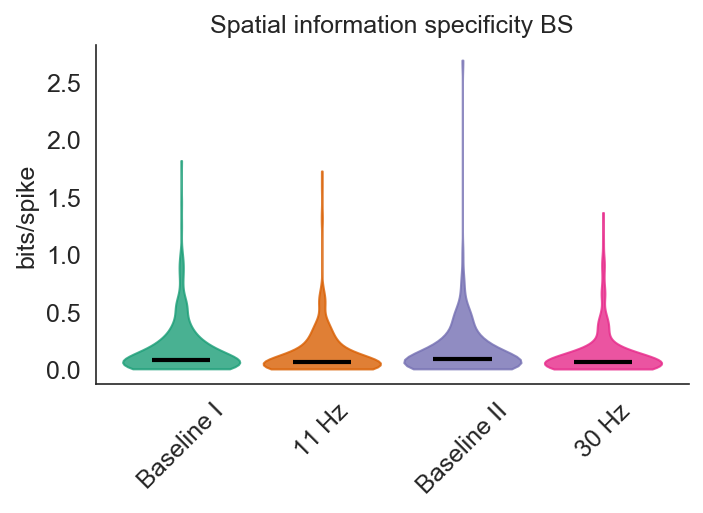

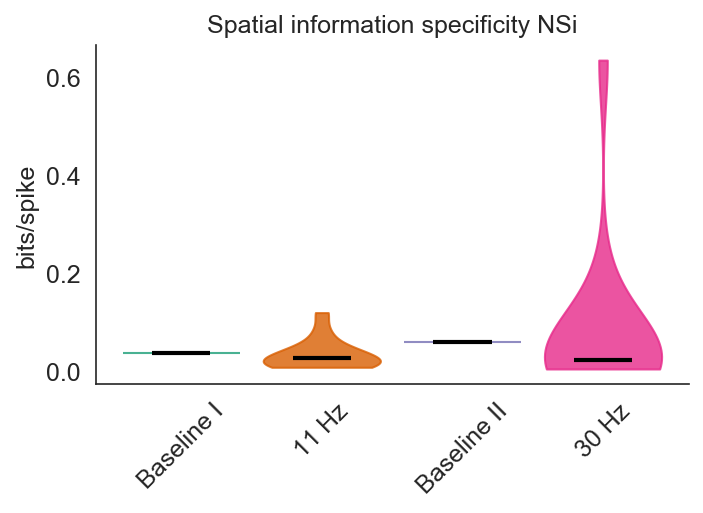

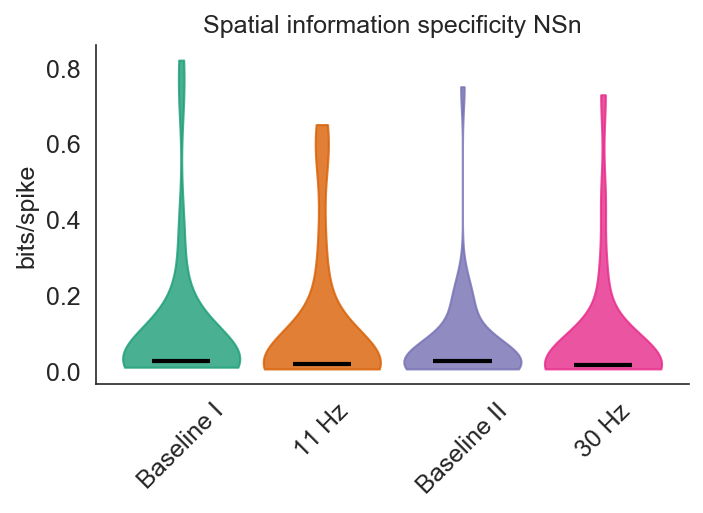

In [56]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['information_specificity'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Spatial information specificity {cell_type}")
    plt.ylabel("bits/spike")
    # plt.ylim(-0.2, 1.6)

    savefig(output_path / "figures" / f"information_specificity_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


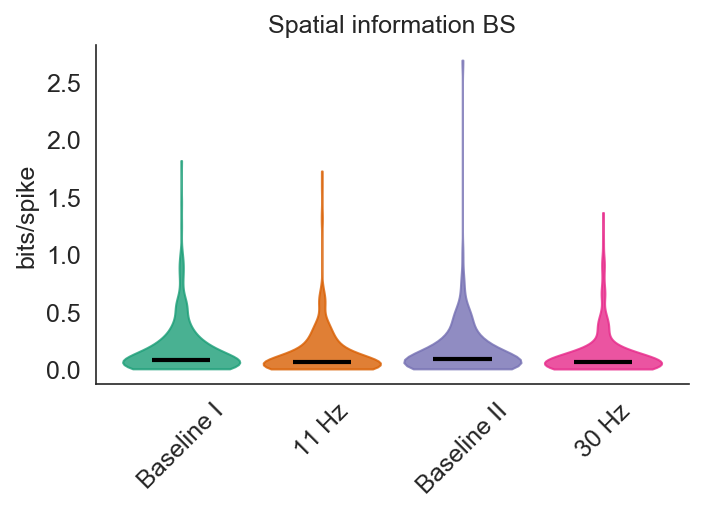

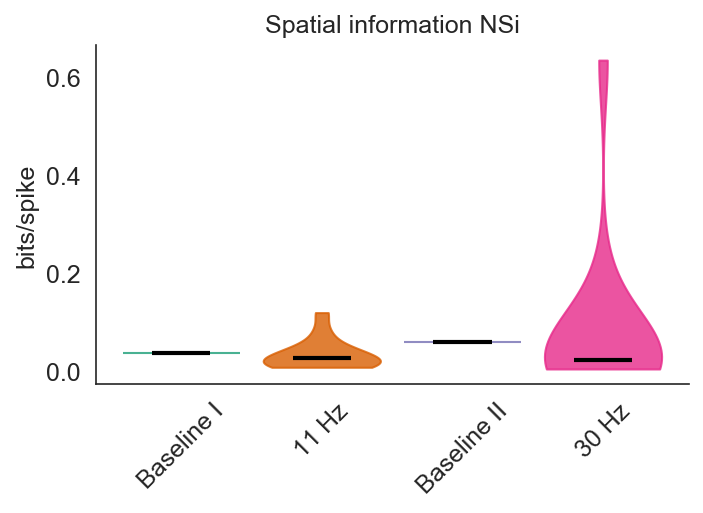

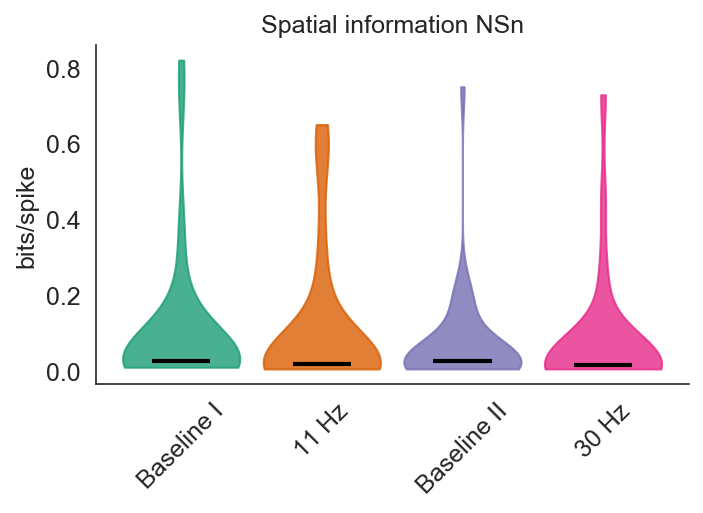

In [57]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['information_specificity'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Spatial information {cell_type}")
    plt.ylabel("bits/spike")
    # plt.ylim(-0.2, 1.6)

    savefig(output_path / "figures" / f"spatial_information_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


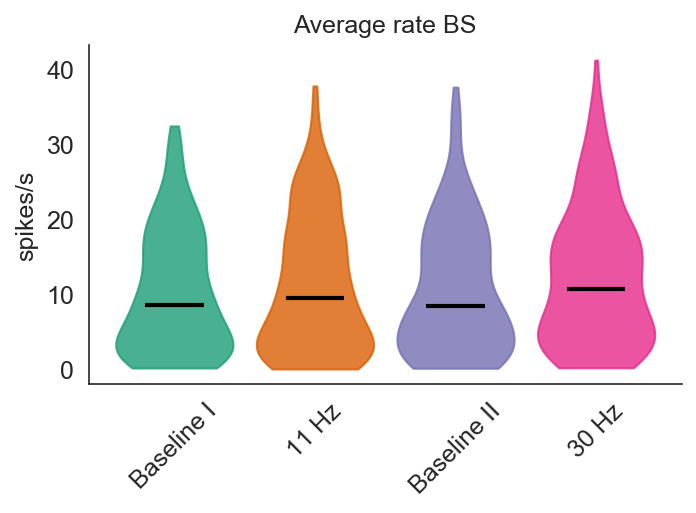

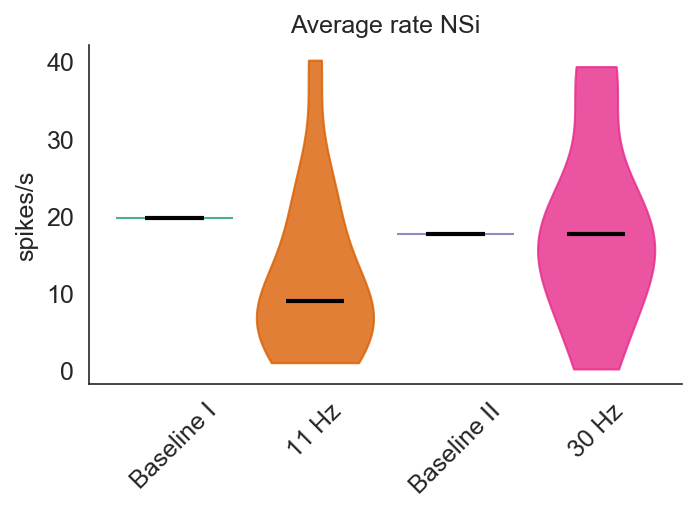

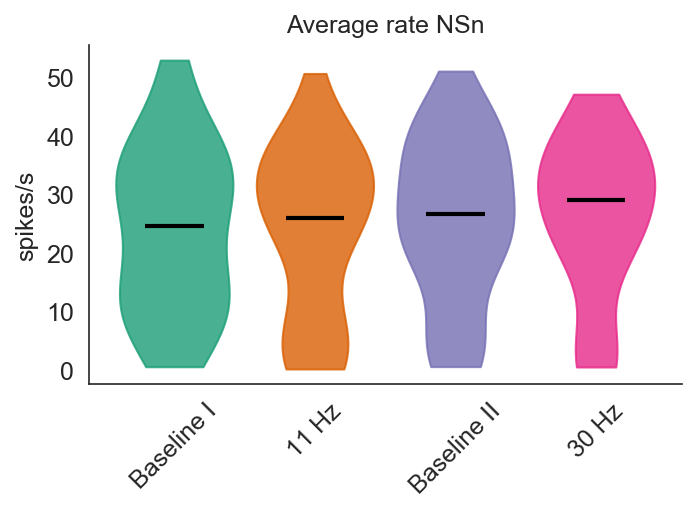

In [59]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['average_rate'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Average rate {cell_type}")
    plt.ylabel("spikes/s")

    savefig(output_path / "figures" / f"average_rate_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


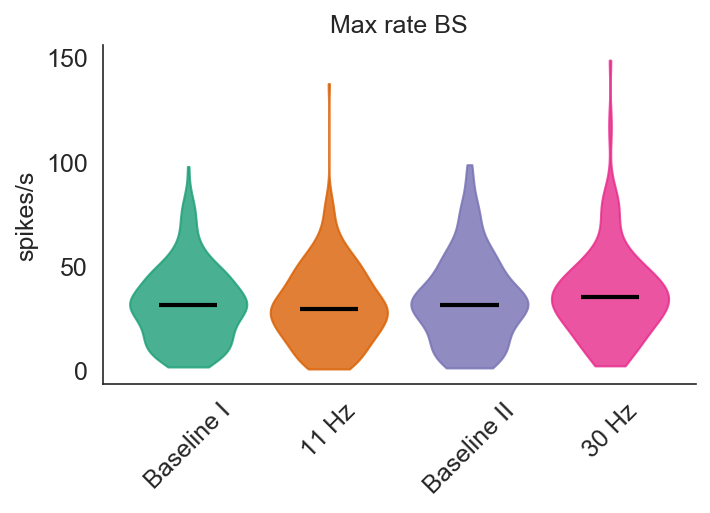

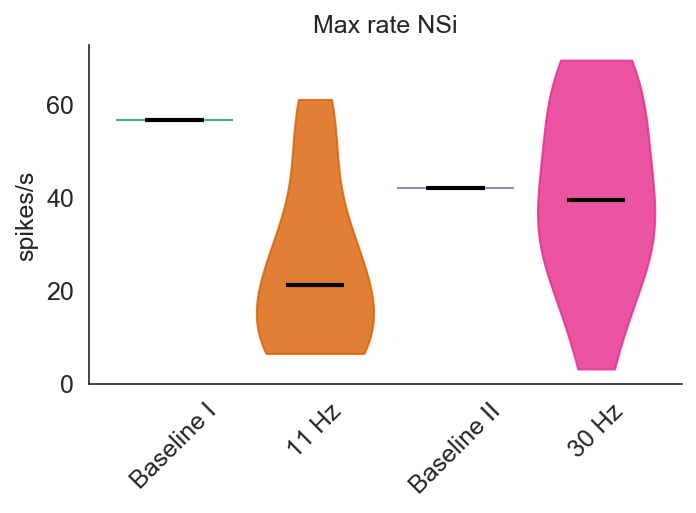

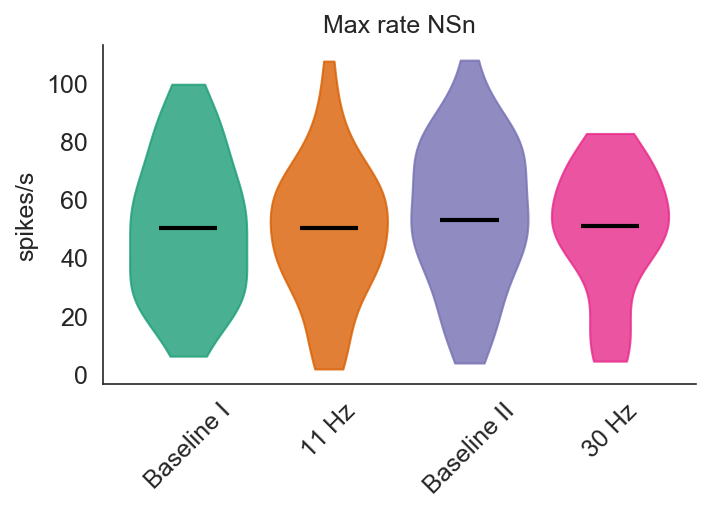

In [60]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['max_rate'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Max rate {cell_type}")
    plt.ylabel("spikes/s")

    savefig(output_path / "figures" / f"max_rate_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


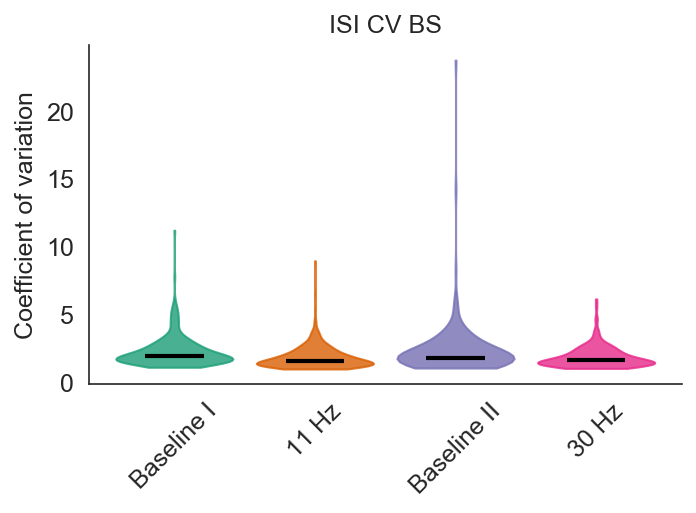

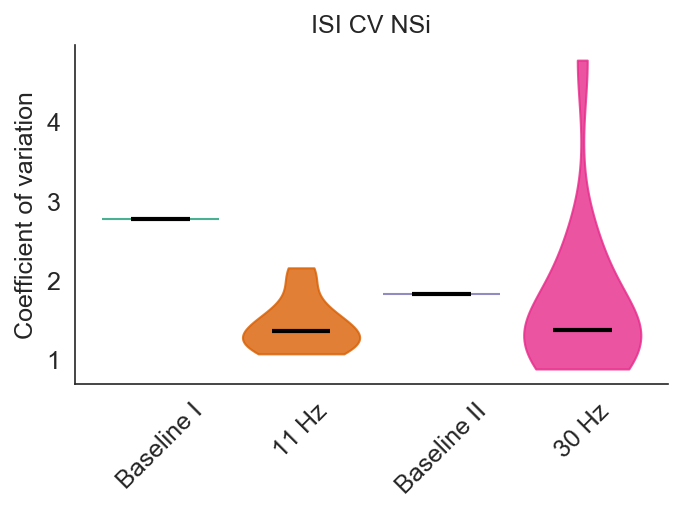

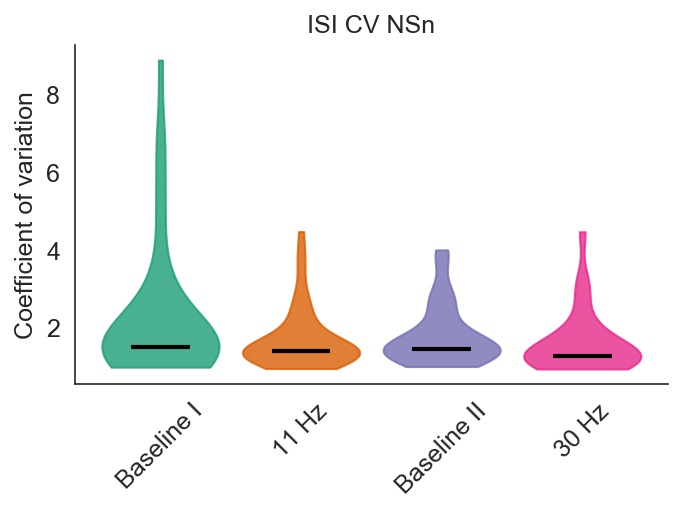

In [61]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['interspike_interval_cv'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"ISI CV {cell_type}")
    plt.ylabel("Coefficient of variation")

    savefig(output_path / "figures" / f"isi_cv_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


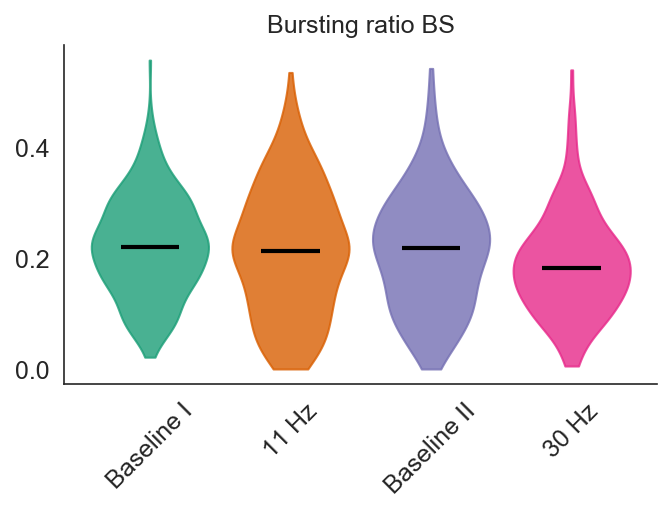

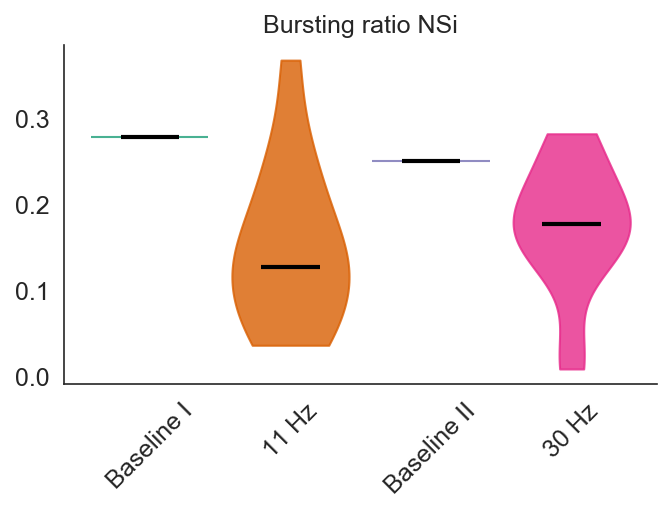

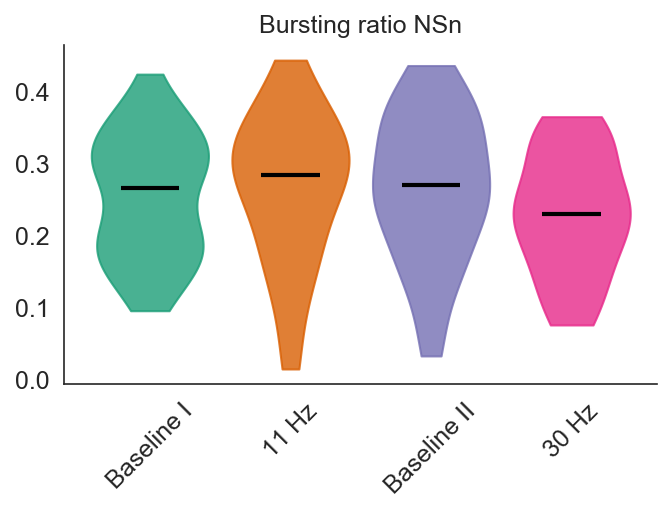

In [62]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['burst_event_ratio'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Bursting ratio {cell_type}")
    plt.ylabel("")

    savefig(output_path / "figures" / f"burst_event_ratio_{cell_type}")

[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]
[0.0, 0.6, 1.2, 1.7999999999999998]


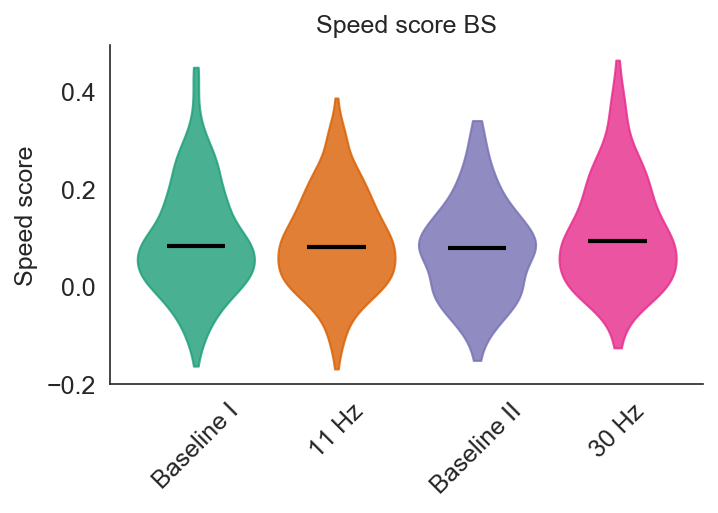

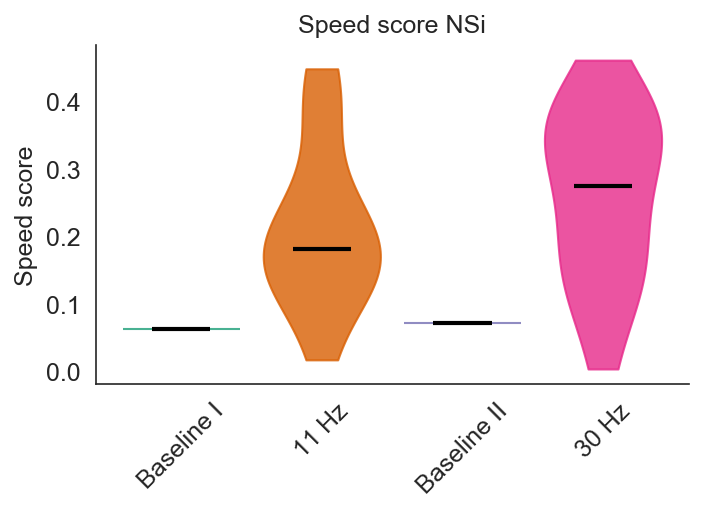

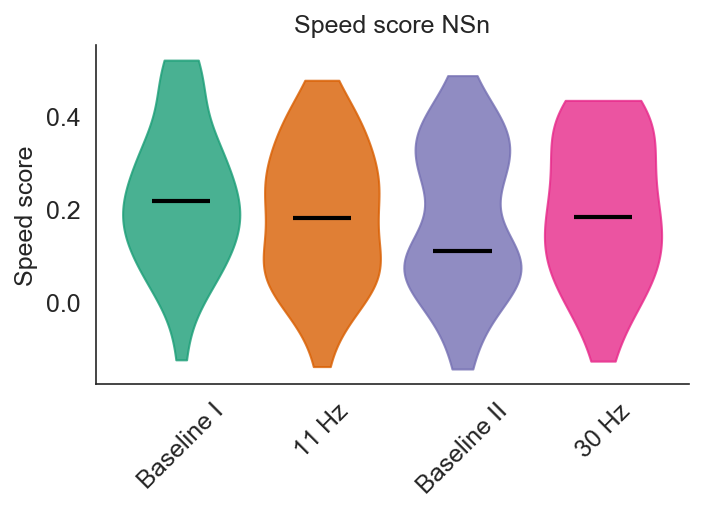

In [63]:
for cell_type, cell_results in results.items():
    plt.figure()
    violinplot([cell_results['speed_score'].loc[:,label].dropna().to_numpy() for label in labels], xticks=labels, colors=colors)
    plt.title(f"Speed score {cell_type}")
    plt.ylabel("Speed score")

    savefig(output_path / "figures" / f"speed_score_{cell_type}")

# Register in Expipe

In [64]:
action = project.require_action("comparisons-allcells")

In [65]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_BS_speed_score.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/statistics_NSi.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_NSn_information_rate.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_BS_information_specificity.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_NSi_selectivity.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_BS_burst_event_ratio.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_NSi_speed_score.tex',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_BS_average_rate.csv',
 '/media/storage/expipe/septum-mec/actions/comparisons-allcells/data/statistics/values_BS_sparsity.csv',
 '/media/st

In [66]:
septum_mec.analysis.registration.store_notebook(action, "20_comparisons_allcells.ipynb")